In [1]:
import torch
from torch import nn
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 128
latent_space = 2

### Data Load

In [5]:
trfs = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=trfs)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_size = len(dataset)
n_classes = len(dataset.classes)

In [6]:
def plot_batch(x_batch, y_batch):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(y_batch[i].numpy())
        image = x_batch[i].squeeze().numpy()
        plt.imshow(image, cmap='gray')
    plt.tight_layout()    

In [7]:
x_batch, y_batch = next(iter(dataloader))
x_batch.shape, y_batch.shape, x_batch[0].max(), x_batch[0].min()

(torch.Size([128, 1, 28, 28]), torch.Size([128]), tensor(1.), tensor(0.))

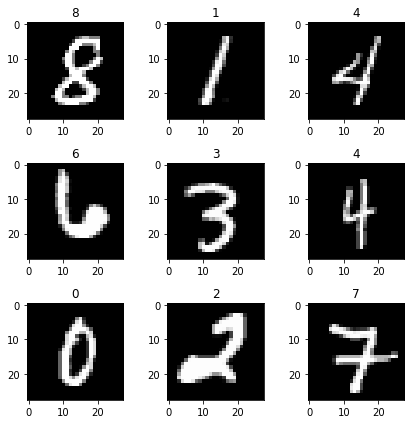

In [8]:
plot_batch(x_batch, y_batch)

### Models

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_space)
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.model(x)
        return y

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space + n_classes, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.model(x)
        y = y.view(-1, 1, 28, 28)
        return y

In [11]:
class Discriminator(nn.Module):
   
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.model(x)
        return y

### Training

In [12]:
def gen_z(i_size):
    return (torch.randn(i_size, latent_space) * 5).to(device)


CPU times: user 12min 25s, sys: 51.8 s, total: 13min 17s
Wall time: 13min 26s


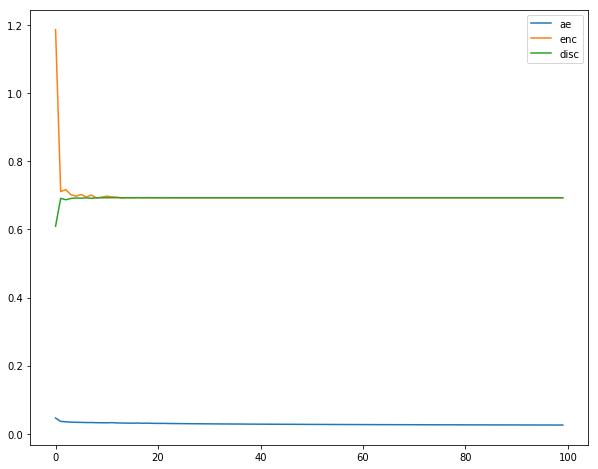

In [13]:
%%time
n_epochs = 100
lr = 1e-3

enc = Encoder().to(device)
dec = Decoder().to(device)

ae_optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()) , lr = lr)
ae_criterion = nn.MSELoss()

disc = Discriminator().to(device)
disc_optimizer = optim.Adam(disc.parameters(), lr = lr)
disc_criterion = nn.BCELoss()

enc_optimizer = optim.Adam(enc.parameters(), lr = lr)
enc_criterion = nn.BCELoss()

ae_loss_hist = []
disc_loss_hist = []
enc_loss_hist = []

with tnrange(n_epochs) as t:
    for e in t:
        t.set_description(f'Epoch: {e}/{n_epochs}')

        ae_epoch_loss = 0.0
        disc_epoch_loss = 0.0
        enc_epoch_loss = 0.0
        for inputs, targets in dataloader:
            i_size = inputs.size(0)

            inputs = inputs.to(device)
            targets = targets.to(device)
            
            y_onehot = torch.zeros((i_size, n_classes), device=device)
            y_onehot.scatter_(1, targets.view(-1, 1), 1)

            # Reconstruction phase
            ae_optimizer.zero_grad()
            z_enc = enc(inputs)
            dec_input = torch.cat((y_onehot, z_enc), 1)
            ae_out = dec(dec_input)

            ae_loss = ae_criterion(ae_out, inputs)
            ae_loss.backward()
            ae_optimizer.step()

            ae_epoch_loss += ae_loss.item() * inputs.size(0)

            # Regularization phase
            ## Discriminator
            z_real = gen_z(i_size)
            z_enc = enc(inputs)
            z_fake = z_enc.detach()

            disc_optimizer.zero_grad()

            disc_input = torch.cat((z_real, z_fake), dim=0)
            disc_y = torch.cat((torch.ones(i_size, 1), torch.zeros(i_size, 1)), dim=0).to(device)

            disc_y_hat = disc(disc_input)

            disc_loss = disc_criterion(disc_y_hat, disc_y)
            disc_loss.backward()
            disc_optimizer.step()

            disc_epoch_loss += disc_loss.item() * disc_input.size(0)

            ## Encoder
            enc_optimizer.zero_grad()

            z_enc = enc(inputs)
            enc_y = disc(z_enc)

            ones = torch.ones(i_size, 1).to(device)
            enc_loss = enc_criterion(enc_y, ones)

            enc_loss.backward()
            enc_optimizer.step()
            enc_epoch_loss += enc_loss.item() * inputs.size(0)

        # End of epoch    
        ae_epoch_loss = ae_epoch_loss/dataset_size
        disc_epoch_loss = disc_epoch_loss/(dataset_size*2)
        enc_epoch_loss = enc_epoch_loss/dataset_size

        t.set_postfix(ae=ae_epoch_loss, disc=disc_epoch_loss, enc=enc_epoch_loss)

        ae_loss_hist.append(ae_epoch_loss)
        disc_loss_hist.append(disc_epoch_loss)
        enc_loss_hist.append(enc_epoch_loss)

plt.figure(figsize=(10, 8))
plt.plot(range(n_epochs), ae_loss_hist, label='ae')
plt.plot(range(n_epochs), enc_loss_hist, label='enc')
plt.plot(range(n_epochs), disc_loss_hist, label='disc')
plt.legend();

In [14]:
print(f'ae loss: {ae_loss_hist[-1]:.3f}\t'
      f'enc loss: {enc_loss_hist[-1]:.3f}\t'
      f'disc loss: {disc_loss_hist[-1]:.3f}')

ae loss: 0.026	enc loss: 0.693	disc loss: 0.693


In [15]:
torch.save(dec.state_dict(), 'aae_style_dec.pth')

### Evaluate Latent Space

In [16]:
dec = Decoder().to(device)
dec.load_state_dict(torch.load('aae_style_dec.pth'))

In [17]:
n_samples = 100

labels = torch.LongTensor(np.tile(np.arange(n_classes), int(n_samples/n_classes)))
labels = labels.to(device)

y_onehot = torch.zeros((n_samples, n_classes), device=device)
y_onehot.scatter_(1, labels.view(-1, 1), 1)
y_onehot.size()

latent = gen_z(n_samples)

samples = torch.cat((y_onehot, latent), dim=1)

targets.size(), y_onehot.size(), latent.size(), samples.size()

(torch.Size([96]),
 torch.Size([100, 10]),
 torch.Size([100, 2]),
 torch.Size([100, 12]))

In [18]:
samples[:3]

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  5.4795,  6.6261],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -5.6098,  1.0680],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.9817, -3.4929]], device='cuda:0')

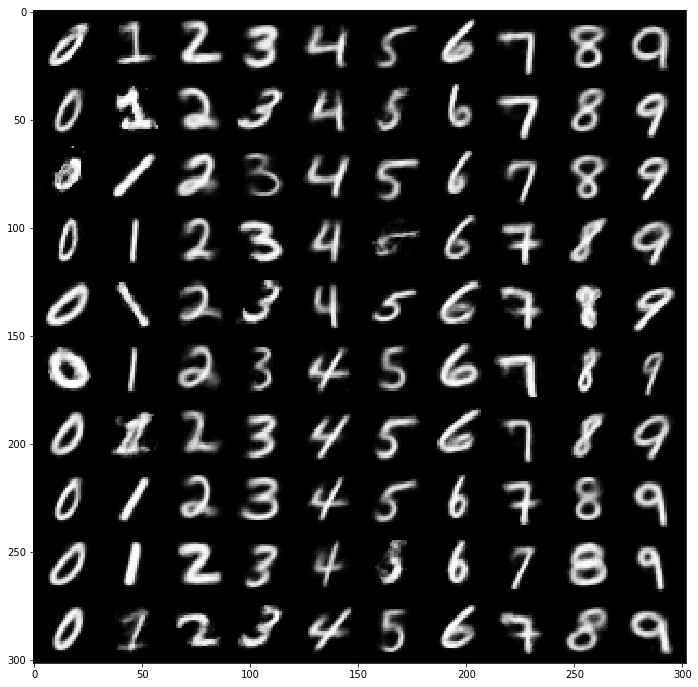

In [19]:
from torchvision.utils import make_grid
samples_imgs = dec(samples)
samples_imgs = samples_imgs.view(samples_imgs.size(0), 1, 28, 28).detach().cpu()
grid_img = make_grid(samples_imgs, 10)
grid_img = grid_img.numpy().transpose(1,2,0)
plt.figure(figsize=(12, 12))
plt.imshow(grid_img);